# Contracts Tutor – Figure F.1: Harmfulness Rates for Instructors and LLMs

This notebook generates **Figure F.1** of the Contracts Tutor paper:

> *Harmfulness rates for instructors and LLMs. Points denote mean harmfulness rates as defined in Supplementary Information F, with non-parametric 95\% bootstrap confidence intervals obtained by resampling responses.*

## Overview

We:
1. **Load** the anonymized pairwise dataset with answer IDs and harmfulness annotations.
2. **Preprocess** model identifiers to distinguish LLMs and human instructors.
3. **Apply** the harmfulness definition from the Supplementary Information:
   - A judge marking a response as harmful at least once makes **all** that judge's ratings of that response harmful.
   - For each response–judge pair, we compute whether that response is harmful.
   - For each model, we compute the distribution of harmfulness rates across responses.
4. **Estimate** mean harmfulness rates for each model and compute **95\% bootstrap confidence intervals** by resampling responses.
5. **Assemble** a tidy DataFrame `df_harmful` with mean rates and confidence bounds.
6. **Plot** a Cleveland-style dot plot of harmfulness rates, matching the published figure and saved as `figures/harmfulness_rate.png`.

Re-running this notebook with the same input data should regenerate the final harmfulness-rate figure.


## 1. Imports

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import beta, t
import matplotlib.pyplot as plt

## 2. Load pairwise data and basic preprocessing

In [2]:
def parse_model_id(model_id):
    """Parse model identifier into model type and name.

    Format
    ------
    - LLMs: ``model_question_version`` (e.g., ``"gemini_q1_v2"``)
    - Professors: ``prof_professorName_question_version`` (e.g., ``"prof_Smith_q1_v1"``)

    Returns
    -------
    model_type : str
        One of ``"gemini"``, ``"nlm"``, or ``"professor"``.
    model_name : str
        Specific name (e.g., ``"gemini"``, ``"nlm"``, or professor last name).
    """
    parts = model_id.split('_')
    
    if parts[0] == 'prof':
        # Professor format: prof_professorName_question_version
        return 'professor', parts[1], parts[3]  # Return professor name
    else:
        # LLM format: model_question_version
        return parts[0], parts[0], parts[2]  # Return model name (gemini or nlm)

def preprocess_data(df):
    """
    Preprocess the dataframe by extracting model information.
    """
    # Extract model types and names for both models
    df['model_a_type'], df['model_a_name'], df['version_a'] = zip(*df['model_a_id'].apply(parse_model_id))
    df['model_b_type'], df['model_b_name'], df['version_b'] = zip(*df['model_b_id'].apply(parse_model_id))
    
    # Extract question number from model_a_id (assuming format is consistent)
    df['question'] = df['model_a_id'].apply(lambda x: x.split('_')[1] if 'prof' not in x else x.split('_')[2])
    
    return df

df = pd.read_csv('pairwise_tutors_data_anonymized.csv')

df = preprocess_data(df)

df = df.copy()

In [3]:
# Use the provided meta IDs directly; they already encode (type, name, q, version)
# If you ever have missing model_*_id, you can reconstruct from (type, name, question_id, version)
df["answer_key_a"] = df["model_a_id"]
df["answer_key_b"] = df["model_b_id"]

# Unordered pair key: sort the two answer keys so (A,B) == (B,A)
def make_pair_key(a, b):
    x, y = sorted([str(a), str(b)])
    return f"{x}||{y}"

df["pair_key"] = df.apply(lambda r: make_pair_key(r["answer_key_a"], r["answer_key_b"]), axis=1)

# Also a per-row "preferred answer id" that is order-invariant for agreement checks
df["preferred_answer_id"] = np.where(
    df["decision"].str.upper().eq("A"), df["answer_key_a"], df["answer_key_b"]
)

## 3. Define harmfulness bootstrap and analysis functions

In [4]:
def bootstrap_confidence_interval(proportions, confidence=0.95, n_bootstrap=1000):
    """Estimate a non-parametric bootstrap confidence interval for mean proportions.

    This resamples the list of response-level proportions with replacement and
    computes percentile-based confidence intervals for the mean.

    Parameters
    ----------
    proportions : array-like
        List or array of per-response harmfulness rates in [0, 1].
    confidence : float, optional
        Confidence level (default 0.95 for a 95% interval).
    n_bootstrap : int, optional
        Number of bootstrap samples (default 1000).

    Returns
    -------
    tuple of float
        ``(lower_bound, upper_bound)`` for the mean proportion.
    """
    if len(proportions) == 0:
        return 0, 0
    
    if len(proportions) == 1:
        # Can't bootstrap with single value, return the value itself
        return proportions[0], proportions[0]
    
    # Convert to numpy array for easier manipulation
    proportions = np.array(proportions)
    
    # Generate bootstrap samples
    bootstrap_means = []
    for _ in range(n_bootstrap):
        # Sample with replacement
        bootstrap_sample = np.random.choice(proportions, size=len(proportions), replace=True)
        bootstrap_means.append(np.mean(bootstrap_sample))
    
    # Calculate confidence interval from bootstrap distribution
    alpha = 1 - confidence
    lower_percentile = (alpha / 2) * 100
    upper_percentile = (1 - alpha / 2) * 100
    
    ci_lower = np.percentile(bootstrap_means, lower_percentile)
    ci_upper = np.percentile(bootstrap_means, upper_percentile)
    
    return ci_lower, ci_upper

In [5]:
def analyze_harmful_answers_new_method(df):
    """Analyze harmful responses using the paper's "new" harmfulness definition.

    Methodology
    -----------
    1. If a judge marks a response as harmful at least once, **all** instances of that
       response rated by that judge are treated as harmful.
    2. For each response–judge pair, compute whether the response is harmful.
    3. For each model, compute the distribution of harmfulness rates across responses
       and summarize them.

    Parameters
    ----------
    df : pandas.DataFrame
        Pairwise dataset with at least response IDs, judge IDs, model identifiers,
        and harmfulness annotations/comments.

    Returns
    -------
    model_harmful_rates : dict
        Overall harmfulness rate per model (in percent).
    judge_model_analysis : dict
        Nested dictionary summarizing, for each judge and model, the harmful rate
        and counts of responses evaluated.
    harmful_statistics : list of dict
        Detailed per-model statistics suitable for constructing a summary DataFrame
        (including bootstrap inputs).
    rows_to_review : pandas.DataFrame
        Rows with unexpected or malformed harmfulness comments.
    model_prop_lists : dict
        Mapping from model name to list of per-response harmfulness proportions
        used in the bootstrap stage.
    """
    
    # Step 1: Identify unique responses and track judge-response pairs
    # We'll use a combination of question + model + response content as unique identifier
    # 
    # IMPORTANT: If a judge sees the same response multiple times and marks it as harmful
    # at least once, we consider that judge finds the response harmful overall
    response_judge_harmful = defaultdict(bool)  # {(response_id, judge): is_harmful}
    judge_response_pairs = defaultdict(set)     # {judge: {response_ids}}
    model_responses = defaultdict(set)          # {model: {response_ids}}
    
    rows_to_review = []
    
    for idx, row in df.iterrows():
        comment = row['comment_cleaned']
        judge = row['judge_name']
        
        # Create unique identifiers for responses A and B
        # Using question_id + model + position to identify unique responses
        response_a_id = f"{row.get('question_id', idx)}_{row['model_a_name']}_{row['version_a']}"
        response_b_id = f"{row.get('question_id', idx)}_{row['model_b_name']}_{row['version_b']}"
        
        model_name_a = row['model_a_name']
        model_name_b = row['model_b_name']
        model_type_a = row['model_a_type']
        model_type_b = row['model_b_type']
        
        # Track all judge-response pairs (for denominator calculation)
        judge_response_pairs[judge].add(response_a_id)
        judge_response_pairs[judge].add(response_b_id)
        
        # Track which responses belong to which models
        model_responses[model_name_a].add(response_a_id)
        model_responses[model_name_b].add(response_b_id)
        
        # Also track by model_type if different from model_name
        if model_type_a != model_name_a:
            model_responses[model_type_a].add(response_a_id)
        if model_type_b != model_name_b:
            model_responses[model_type_b].add(response_b_id)
        
        # Process harmful markings
        # Key Logic: If this judge has EVER marked this response as harmful,
        # keep it marked as harmful (don't overwrite True with False)
        if pd.isna(comment):
            # No harmful answer in this instance
            # Only mark as False if we haven't seen this judge mark these responses as harmful before
            if (response_a_id, judge) not in response_judge_harmful:
                response_judge_harmful[(response_a_id, judge)] = False
            if (response_b_id, judge) not in response_judge_harmful:
                response_judge_harmful[(response_b_id, judge)] = False
            
        elif comment == "Answer A: Low Quality":
            # Response A is harmful - mark as True (this will persist even if seen again as non-harmful)
            response_judge_harmful[(response_a_id, judge)] = True
            # Response B is not harmful in this instance
            if (response_b_id, judge) not in response_judge_harmful:
                response_judge_harmful[(response_b_id, judge)] = False
            
        elif comment == "Answer B: Low Quality":
            # Response B is harmful - mark as True (this will persist)
            response_judge_harmful[(response_b_id, judge)] = True
            # Response A is not harmful in this instance
            if (response_a_id, judge) not in response_judge_harmful:
                response_judge_harmful[(response_a_id, judge)] = False
            
        elif comment == 'Answer A: Low Quality, Answer B: Low Quality':
            # Both responses are harmful - mark as True (these will persist)
            response_judge_harmful[(response_a_id, judge)] = True
            response_judge_harmful[(response_b_id, judge)] = True
            
        else:
            # Unexpected format - save for manual review
            rows_to_review.append({
                'index': idx,
                'comment': comment,
                'judge': judge,
                'model_name_a': model_name_a,
                'model_name_b': model_name_b,
                'model_type_a': model_type_a,
                'model_type_b': model_type_b
            })
            # For unexpected formats, only mark as False if not already marked as harmful
            if (response_a_id, judge) not in response_judge_harmful:
                response_judge_harmful[(response_a_id, judge)] = False
            if (response_b_id, judge) not in response_judge_harmful:
                response_judge_harmful[(response_b_id, judge)] = False
    
    # Step 2: For each unique response, find which judges marked it as harmful at least once
    # This implements the core logic: "proportion of judges who found this response harmful"
    unique_responses = set()
    for response_set in model_responses.values():
        unique_responses.update(response_set)
    
    response_harmful_judges = {}  # {response_id: proportion_of_judges_who_found_harmful}
    
    for response_id in unique_responses:
        # Find all judges who evaluated this specific response
        judges_who_saw_response = [judge for judge in judge_response_pairs 
                                 if response_id in judge_response_pairs[judge]]
        
        if not judges_who_saw_response:
            continue
            
        # Count judges who marked this response as harmful (at least once)
        judges_who_found_harmful = [judge for judge in judges_who_saw_response 
                                  if response_judge_harmful.get((response_id, judge), False)]
        
        # Calculate proportion: # judges who found harmful / # judges who saw it
        if len(judges_who_found_harmful) > len(judges_who_saw_response):
            print(f'ERROR. judges who found harmful ({len(judges_who_found_harmful)})> judges who saw response ({len(judges_who_saw_response)})')
        if len(judges_who_saw_response) > 16:
            print(f'ERRROR. Judges who saw response ({len(judges_who_saw_response)}) > 16')
        harmful_proportion = len(judges_who_found_harmful) / len(judges_who_saw_response)
        response_harmful_judges[response_id] = {
            'harmful_proportion': harmful_proportion,
            'total_judges': len(judges_who_saw_response),
            'harmful_judges': len(judges_who_found_harmful)
        }
    
    # Step 3: Calculate model-level harmful rates (average across responses)
    model_harmful_rates = {}
    harmful_statistics = []
    model_prop_lists = defaultdict(list)
    
    for model, response_set in model_responses.items():
        if not response_set:
            continue
            
        # Get harmful proportions for all responses from this model
        model_response_proportions = []
        total_harmful_responses = 0
        total_responses = 0
        
        for response_id in response_set:
            if response_id in response_harmful_judges:
                prop_data = response_harmful_judges[response_id]
                model_response_proportions.append(prop_data['harmful_proportion'])
                
                if prop_data['harmful_proportion'] > 0:  # At least one judge found it harmful
                    total_harmful_responses += 1
                total_responses += 1
        
        if model_response_proportions:
            # Average harmful rate across all responses for this model
            avg_harmful_rate = np.mean(model_response_proportions)
            model_harmful_rates[model] = avg_harmful_rate * 100  # Convert to percentage
            
            # Calculate confidence interval using bootstrap method
            # This is appropriate since we're averaging proportions across responses
            ci_lower, ci_upper = bootstrap_confidence_interval(model_response_proportions)
            
            harmful_statistics.append({
                'model': model,
                'comparison_type': 'harmful_rate_new',
                'opponent': 'all',
                'win_rate': avg_harmful_rate,
                'wins': total_harmful_responses,  # Number of responses with >0% harmful rate
                'total_comparisons': total_responses,
                'ci_lower': ci_lower,
                'ci_upper': ci_upper,
                'ci_width': ci_upper - ci_lower,
                'avg_across_responses': True,
                'n_responses': len(model_response_proportions)  # For reference
            })
            
            model_prop_lists[model] = model_response_proportions
    
    # Step 4: Judge-level analysis - how each judge rates each model
    judge_model_analysis = defaultdict(dict)
    
    for judge in judge_response_pairs:
        judge_model_stats = defaultdict(lambda: {'harmful_responses': 0, 'total_responses': 0, 'response_ids': []})
        
        # For each response this judge evaluated
        for response_id in judge_response_pairs[judge]:
            # Find which model this response belongs to
            for model, model_response_set in model_responses.items():
                if response_id in model_response_set:
                    judge_model_stats[model]['total_responses'] += 1
                    judge_model_stats[model]['response_ids'].append(response_id)
                    
                    # Check if this judge found this response harmful
                    if response_judge_harmful.get((response_id, judge), False):
                        judge_model_stats[model]['harmful_responses'] += 1
        
        # Calculate harmful rates for each model this judge evaluated
        for model, stats in judge_model_stats.items():
            if stats['total_responses'] > 0:
                harmful_rate = stats['harmful_responses'] / stats['total_responses']
                judge_model_analysis[judge][model] = {
                    'harmful_rate': harmful_rate * 100,  # Convert to percentage
                    'harmful_count': stats['harmful_responses'],
                    'total_count': stats['total_responses'],
                    'unique_responses_evaluated': len(set(stats['response_ids']))
                }
    
    return model_harmful_rates, dict(judge_model_analysis), harmful_statistics, pd.DataFrame(rows_to_review), dict(model_prop_lists)

## 4. Run harmfulness analysis and construct summary DataFrame

In [6]:
harmful_rates, judge_analysis, statistics, review_rows, proportion_lists = analyze_harmful_answers_new_method(df)

In [7]:
df_harmful = pd.DataFrame(statistics)

In [8]:
def create_harmful_rate_plot(df, show_individual_ci=True, save_path=None):
    """Create Figure F.1: harmfulness rates with 95% bootstrap confidence intervals.

    Expects a tidy summary DataFrame where each row corresponds to a model
    (LLM or instructor aggregate/individual) and includes harmfulness rates and
    confidence intervals.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with columns such as ``model``, ``comparison_type``, ``opponent``,
        ``win_rate`` (harmful rate as proportion or percent), and ``ci_lower``/``ci_upper``.
    show_individual_ci : bool, optional
        If True, show confidence intervals for individual instructors as well as
        aggregate models.
    save_path : str or Path, optional
        If provided, save the figure to this path (e.g., ``"figures/harmfulness_rate.png"``).

    Notes
    -----
    This function is intended to reproduce Figure F.1 of the paper: points are
    mean harmfulness rates and horizontal bars are non-parametric 95% bootstrap
    confidence intervals obtained by resampling responses.
    """

    def _to_percent(s):
        # If values look like proportions (<=1), convert to %
        s = s.astype(float)
        if s.max(skipna=True) <= 1.0:
            return 100.0 * s
        return s

    # --- Filter to the rows we actually need ---
    dfh = df.copy()
    if 'comparison_type' in dfh.columns:
        dfh = dfh[dfh['comparison_type'].str.lower() == 'harmful_rate_new']
    if 'opponent' in dfh.columns:
        dfh = dfh[dfh['opponent'].str.lower() == 'all']

    if dfh.empty:
        raise ValueError("No rows found for harmful_rate_new with opponent=all.")

    # --- Normalize to percentage scale ---
    dfh['rate_percent'] = _to_percent(dfh['win_rate'])
    if 'ci_lower' in dfh and 'ci_upper' in dfh:
        dfh['ci_lower_percent'] = _to_percent(dfh['ci_lower'])
        dfh['ci_upper_percent'] = _to_percent(dfh['ci_upper'])
    else:
        dfh['ci_lower_percent'] = np.nan
        dfh['ci_upper_percent'] = np.nan

    # --- Partition: main rows (Gemini, NLM, Instructor aggregate) vs. individuals ---
    MAIN_ORDER = ['gemini', 'nlm', 'professor']
    colors = {
        'gemini': '#B2182B',     # red
        'nlm': '#2166AC',        # blue
        'professor': '#1B7837',  # green
        'individual': '#1B7837'  # same green for prof individuals
    }

    def _pick_first(model_name):
        sub = dfh[dfh['model'].str.lower() == model_name.lower()]
        return None if sub.empty else sub.iloc[0]

    rows = []

    # Add main rows if present
    for m in MAIN_ORDER:
        r = _pick_first(m)
        if r is not None:
            label = {'gemini': 'Gemini', 'nlm': 'NotebookLM', 'professor': 'Instructors'}[m]
            rows.append({
                'label': label,
                'rate': r['rate_percent'],
                'lo': r['ci_lower_percent'],
                'hi': r['ci_upper_percent'],
                'is_main': True,
                'color': colors[m],
                'original_model': r['model'],
                'n': r.get('n_responses', r.get('total_comparisons', np.nan))
            })

    # Individual instructors: anything not in the main set
    indiv = dfh[~dfh['model'].str.lower().isin(MAIN_ORDER)].copy()

    for i, r in enumerate(indiv.itertuples(index=False), 1):
        rows.append({
            'label': r.model.title(),
            'rate': r.rate_percent,
            'lo': getattr(r, 'ci_lower_percent', np.nan),
            'hi': getattr(r, 'ci_upper_percent', np.nan),
            'is_main': False,
            'color': colors['individual'],
            'original_model': getattr(r, 'model'),
            'n': getattr(r, 'n_responses', getattr(r, 'total_comparisons', np.nan)),
            'order' : int(r.model.split('or')[1])
        })

    plot_df = pd.DataFrame(rows)
    if plot_df.empty:
        raise ValueError("No rows to plot after processing harmful rates.")

    # Order: main first (by rate), then individuals (already sorted if sort_desc=True)
    main = plot_df[plot_df['is_main']].sort_values('rate', ascending=True)
    indiv = plot_df[~plot_df['is_main']].sort_values('order', ascending=True)
    plot_df = pd.concat([main, indiv], ignore_index=True)

    # --- Plot ---
    fig_h, ax = plt.subplots(figsize=(10, max(5.5, 0.55 * len(plot_df))))
    y = np.arange(len(plot_df))[::-1]

    # CI bars and points
    for i, row in enumerate(plot_df.itertuples(index=False)):
        yy = y[i]
        if (not np.isnan(row.lo)) and (not np.isnan(row.hi)) and (row.is_main or show_individual_ci):
            ax.plot([row.lo, row.hi], [yy, yy], color=row.color, linewidth=4, alpha=0.3, zorder=1)
        ax.scatter(row.rate, yy, s=110, color=row.color, edgecolor='white', linewidth=1.2, zorder=2)

    # Labels (indent individuals)
    ylabels = [r.label if r.is_main else f"    {r.label}" for r in plot_df.itertuples(index=False)]
    ax.set_yticks(y)
    ax.set_yticklabels(ylabels)
    for tick, r in zip(ax.get_yticklabels(), plot_df.itertuples(index=False)):
        tick.set_color(r.color)
        tick.set_fontweight('bold' if r.is_main else 'normal')
        tick.set_fontsize(12 if r.is_main else 10)

    # Axis, grid, limits
    ax.set_xlabel('Harmful rate (%)', fontsize=12)
    ax.set_xlim(0, 100)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Simple legend
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='gray', linestyle='None', markersize=8, label='Point estimate'),
        plt.Line2D([0], [0], color='gray', linewidth=4, alpha=0.3, label='95% Confidence Interval')
    ]
    ax.legend(handles=legend_handles, loc='lower right', frameon=True, fontsize=10)

    plt.tight_layout()

    if save_path is not None:
        from pathlib import Path
        Path(save_path).parent.mkdir(exist_ok=True, parents=True)
        fig_h.savefig(save_path, dpi=300, bbox_inches="tight")

    return fig_h, ax

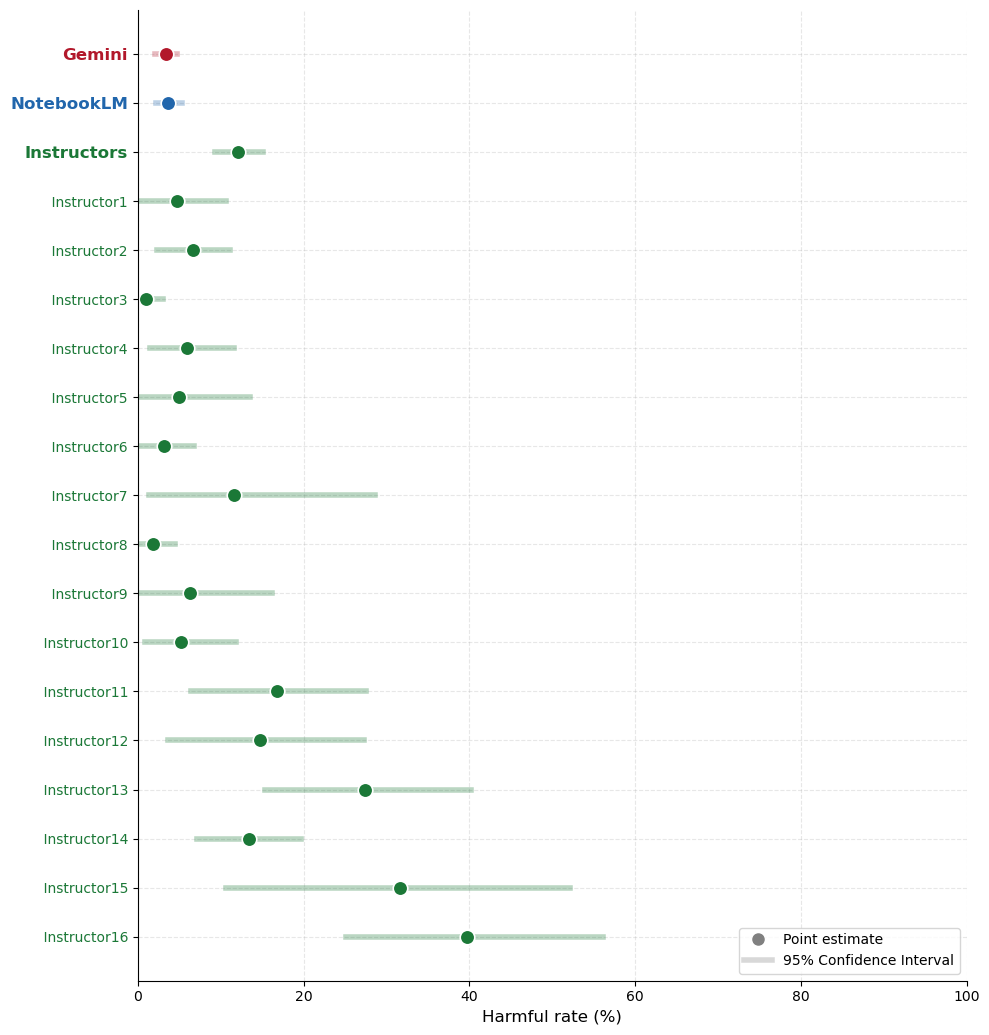

In [9]:
# Generate and save Figure F.1 (harmfulness rates)
fig_h, ax_h = create_harmful_rate_plot(
    df_harmful,
    show_individual_ci=True,
    save_path="figures/harmfulness_rate.png",
)
